# Notes


Selenium needs to be installed:  
``pip install requests beautifulsoup4`` 
``pip install selenium``




# Selenium Approach

## Recursive Mention Crawler

When this code is run it opens chrome and ask to log in on twitter, this is required because twitter has too much limitation for guest users.

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import re
from collections import defaultdict
import json
import os

# ---------- CONFIGURATION ----------
MAX_DEPTH = 2
MAX_TWEETS = 10
WAIT_TIME = 2

# ---------- UTILITY FUNCTIONS ----------
def extract_mentions(text):
    return re.findall(r"@\w+", text)

# ---------- TWITTER SCRAPER ----------
def login_to_twitter():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get("https://twitter.com/login")
    print("\n🔐 Please log in manually in the opened browser window.")
    input("✅ Press ENTER after you have successfully logged in...\n")
    return driver

def wait_for_tweets(driver, timeout=10):
    try:
        WebDriverWait(driver, timeout).until(
            EC.presence_of_element_located((By.XPATH, "//article"))
        )
    except:
        print("⚠️ Timeout waiting for tweets to load.")

def scrape_mentions(driver, username):
    url = f"https://twitter.com/{username}"
    print(f"Opening: {url}")
    driver.get(url)
    wait_for_tweets(driver)

    # Scroll and wait
    scroll_attempts = 0
    while len(driver.find_elements(By.XPATH, "//article")) < MAX_TWEETS and scroll_attempts < 6:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(WAIT_TIME)
        scroll_attempts += 1

    tweets = driver.find_elements(By.XPATH, "//article")[:MAX_TWEETS]
    print(f"🧪 Found {len(tweets)} tweet articles on @{username}")
    if not tweets:
        print(f"⚠️ No tweets extracted for @{username}. Consider increasing WAIT_TIME or checking profile access.")

    mentions = set()
    for i, tweet in enumerate(tweets):
        spans = tweet.find_elements(By.XPATH, ".//span")
        text = " ".join(span.text for span in spans if span.text.strip())
        found = extract_mentions(text)
        if found:
            print(f"    ↳ Mentions: {found}")
        mentions.update(found)

    return list(mentions)


# ---------- RECURSIVE CRAWLER ----------
def crawl_mentions_network(start_user):
    driver = login_to_twitter()
    visited = set()
    edges = []

    def dfs(user, depth):
        if depth > MAX_DEPTH or user in visited:
            return
        visited.add(user)
        try:
            mentions = scrape_mentions(driver, user)
        except Exception as e:
            print(f"❌ Failed to scrape @{user}: {e}")
            return

        for mentioned in mentions:
            mentioned_user = mentioned[1:]  # Remove '@'
            edges.append((user, mentioned_user))
            dfs(mentioned_user, depth + 1)
    
    dfs(start_user, 0)
    driver.quit()
    return edges

# ---------- MAIN ----------
if __name__ == "__main__":
    start_username = "WgPaulo"  # Replace with your starting point
    mention_edges = crawl_mentions_network(start_username)

    # Save JSON
    json_name = f"{start_username}_{MAX_DEPTH}_{MAX_TWEETS}.json"
    json_path = os.path.join("mention_networks", json_name)
    
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(mention_edges, f, indent=2)
    
    print(f"\n✅ Saved mention graph to {json_path}")

    print("\n📈 Mention Edges:")
    for source, target in mention_edges:
        print(f"{source} -> {target}")



🔐 Please log in manually in the opened browser window.
Opening: https://twitter.com/WgPaulo
⚠️ Timeout waiting for tweets to load.
🧪 Found 10 tweet articles on @WgPaulo
    ↳ Mentions: ['@IndiePumpCom']
    ↳ Mentions: ['@DrKuchoGames']
    ↳ Mentions: ['@SoyVixterDev', '@WgPaulo']
    ↳ Mentions: ['@WgPaulo']
    ↳ Mentions: ['@_akhaliq']
    ↳ Mentions: ['@SoyVixterDev', '@WgPaulo']
    ↳ Mentions: ['@JakeSucky']
    ↳ Mentions: ['@SoyVixterDev', '@WgPaulo']
    ↳ Mentions: ['@SoyVixterDev', '@eldonutjaja']
    ↳ Mentions: ['@SoyVixterDev']
Opening: https://twitter.com/DrKuchoGames
⚠️ Timeout waiting for tweets to load.
🧪 Found 10 tweet articles on @DrKuchoGames
    ↳ Mentions: ['@TVKENICHI04']
    ↳ Mentions: ['@DrKuchoGames']
    ↳ Mentions: ['@Xbox', '@Xbox', '@ID_Xbox']
    ↳ Mentions: ['@DrKuchoGames']
    ↳ Mentions: ['@DrKuchoGames']
    ↳ Mentions: ['@GamingTwic', '@DrKuchoGames']
    ↳ Mentions: ['@PressPlayNews', '@DrKuchoGames', '@insomniacgames', '@KillKnightGame']
    ↳

# Visualization of the Graph

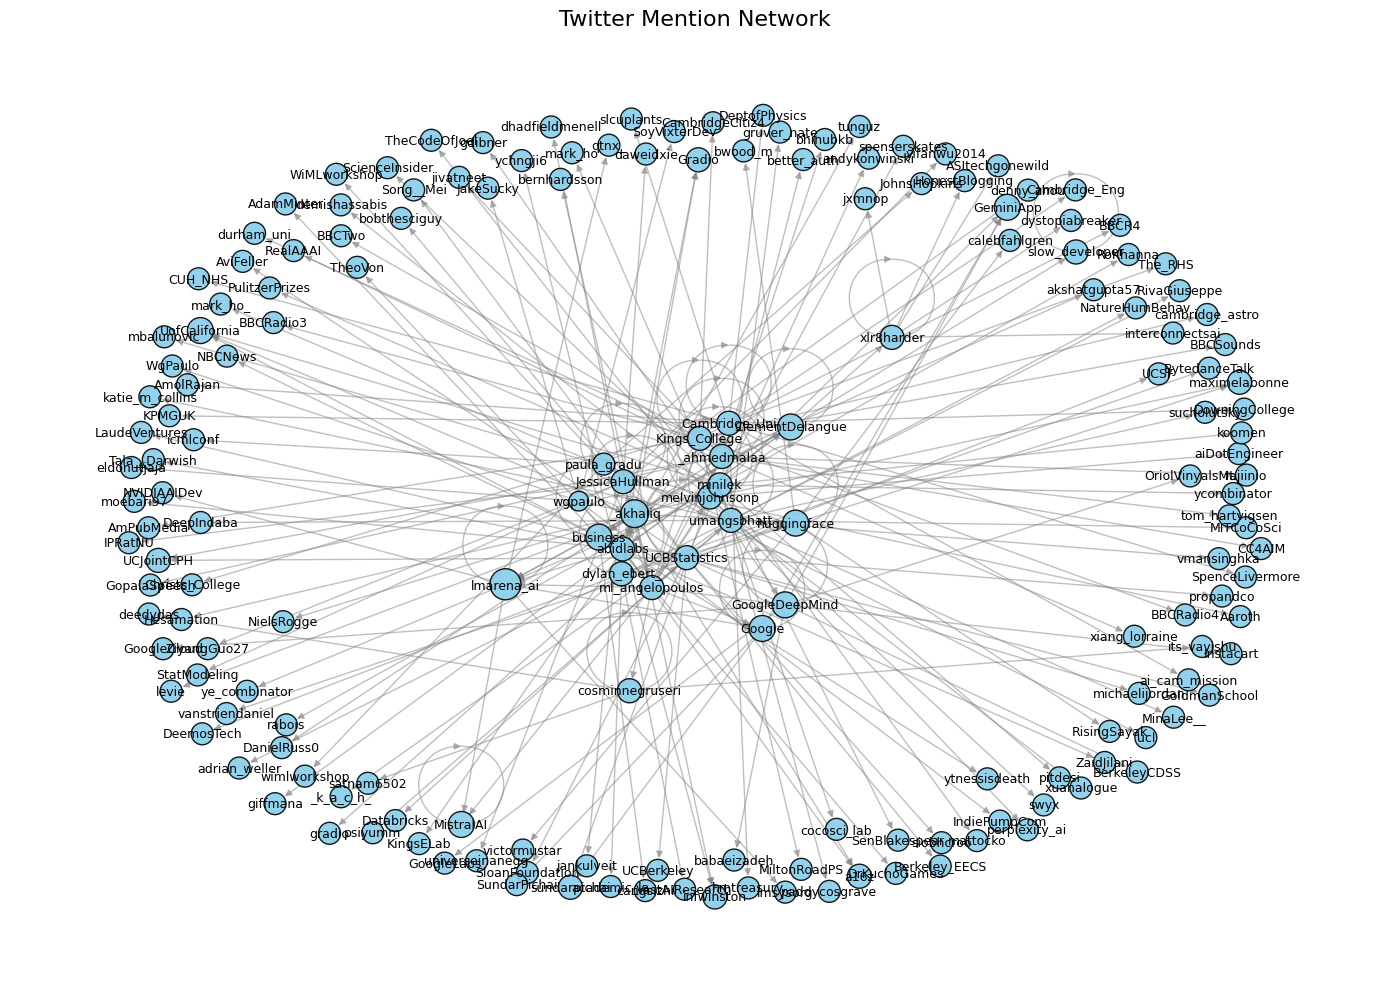

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/WgPaulo_2_10.json"

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Node size based on in-degree (times mentioned)
mention_counts = dict(G.in_degree())
node_sizes = [200 + 50 * mention_counts.get(node, 0) for node in G.nodes()]

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


# Depth Hihglighted

D:\Anaconda\Anaconda\envs\DataMining\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


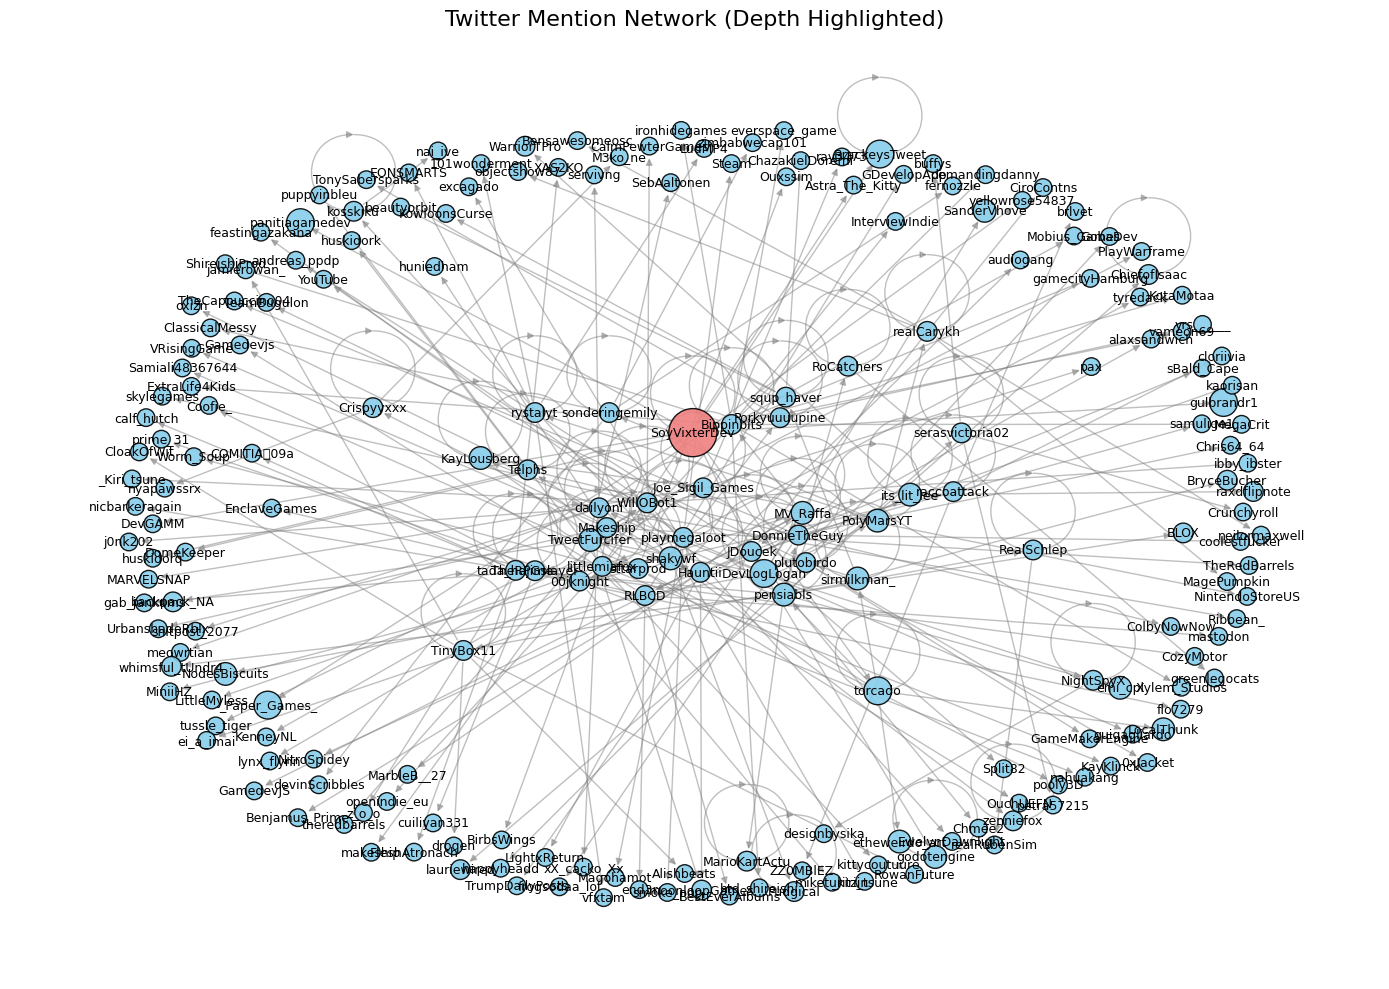

In [78]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os

# ---------- CONFIGURATION ----------
json_file = "mention_networks/SoyVixterDev_3_10.json"
start_user = "SoyVixterDev"  # Starting node to highlight

# ---------- LOAD JSON ----------
if not os.path.exists(json_file):
    raise FileNotFoundError(f"❌ JSON file not found: {json_file}")

with open(json_file, "r", encoding="utf-8") as f:
    edges = json.load(f)

# ---------- BUILD GRAPH ----------
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute shortest path length from start_user
depths = dict(nx.single_source_shortest_path_length(G, start_user))

# Node size based on depth (closer = bigger)
max_depth = max(depths.values()) if depths else 1
node_sizes = []
node_colors = []
for node in G.nodes():
    if node == start_user:
        node_sizes.append(1200)
        node_colors.append("lightcoral")  # Highlight starting node
    else:
        depth = depths.get(node, max_depth + 1)
        size = 800 / (depth + 1)
        node_sizes.append(size)
        node_colors.append("skyblue")

# ---------- DRAW GRAPH ----------
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, edgecolors="black")
nx.draw_networkx_edges(G, pos, edge_color="gray", arrows=True, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title("Twitter Mention Network (Depth Highlighted)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()